# Continuos Regression with *KQM*

### Concept

We will set `output_dim = 2` so that the model would predict a $2-\dim$ vector: $[cos^2\theta, sin^2\theta]$, and we will actually do the inference over $\theta$. Therefore, the range of the output variable must be within $[0, \pi/2]$.

### Import libraries

In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, MinMaxScaler, Normalizer
from sklearn.decomposition import PCA
from sklearn import metrics
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from keras.layers import Input, Dense, Dropout, Activation
from keras.models import Model
from keras import optimizers
from keras import losses
import concurrent.futures
from itertools import product
from keras.layers import Input, Dense, Reshape
import kqm
import itertools
print("Tensorflow version:",tf.__version__)

2024-10-22 22:21:38.613422: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-10-22 22:21:38.641248: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-22 22:21:38.641292: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-22 22:21:38.642092: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-22 22:21:38.646501: I tensorflow/core/platform/cpu_feature_guar

Tensorflow version: 2.15.0


In [2]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')

2024-10-22 22:21:41.255651: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-10-22 22:21:41.291444: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-10-22 22:21:41.291622: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

### Check GPU

In [3]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Tue Oct 22 22:21:45 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.183.01             Driver Version: 535.183.01   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA RTX A2000 8GB Lap...    Off | 00000000:01:00.0 Off |                  N/A |
| N/A   53C    P8               5W /  40W |      9MiB /  8192MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

# Loading Dataset

## RE: Wine Quality
https://archive.ics.uci.edu/dataset/477/real+estate+valuation+data+set

In [4]:
#!pip install ucimlrepo
from ucimlrepo import fetch_ucirepo 

# fetch dataset 
wine_quality = fetch_ucirepo(id=186) 
  
# data (as pandas dataframes) 
X = wine_quality.data.features 
y = wine_quality.data.targets 

## 70% - 30% Hold Out and MinMax Scaling for `y` 

In [5]:
from sklearn.model_selection import train_test_split

# Split data into 70% training and 30% testing
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print(f"Training set size: {X_train.shape}")
print(f"Test set size: {X_test.shape}")

X_train = np.asarray(X_train)
X_test = np.asarray(X_test)

scaler_x = StandardScaler()
scaler_x.fit(X_train)
X_train = scaler_x.transform(X_train)
X_test = scaler_x.transform(X_test)

scaler = MinMaxScaler(feature_range=(0.2, np.pi/2-0.2))
scaler.fit(y_train)
y_train = scaler.transform(y_train)
#y_test = scaler.transform(y_test))
y_train = np.asarray(y_train).reshape(-1)
y_test = np.asarray(y_test).reshape(-1)

print(f"Training features size: {X_train.shape}")
print(f"Training labels size: {y_train.shape}")

Training set size: (4547, 11)
Test set size: (1950, 11)
Training features size: (4547, 11)
Training labels size: (4547,)


## Defining KQM-Model

In [6]:
n_comp=32

In [7]:
class KQMModel:
    def __init__(self,
                 encoding_dim,
                 kernel_function,
                 num_hidden_layerss,
                 input_shape=(11,),
                 output_dim=2,
                 n_comp=n_comp,
                 sigma=0.1,
                 use_dense_layers=True):
        self.encoding_dim = encoding_dim
        self.kernel_function = kernel_function
        self.num_hidden_layerss = num_hidden_layerss
        self.input_shape = input_shape
        self.output_dim = output_dim
        self.n_comp = n_comp
        self.sigma = sigma
        self.use_dense_layers = use_dense_layers  # New parameter tio turn off the dense layer model
        self.encoder = None
        self.encoder_aux = None
        self.kqm_class_encoded = None
        self.kqm_class_out = None
        self.kqm_unit_encoded = None
        self.kqm_unit_out = None
        self.kernel_encoded = None  # almacenamos la instancia de kernel
        self.kernel_out = None  # almacenamos la instancia de kernel
        self.build_model()

    def build_model(self):
        inputs = Input(shape=self.input_shape)
        
        if self.use_dense_layers:
            encoded = Dense(self.encoding_dim, activation='relu')(inputs)
            encoded = Dropout(0.1)(encoded)
            if self.num_hidden_layerss == 2:
                encoded = Dense(self.encoding_dim, activation='relu')(encoded)
                encoded = Dropout(0.1)(encoded)
            out = Dense(self.encoding_dim)(encoded)
            encoded = Activation('tanh')(out)
        else:
            # Skip dense layers, directly output the input
            encoded = inputs
            out = inputs
            #self.encoding_dim=1
        
        self.encoder = Model(inputs, encoded)
        self.encoder_aux = Model(inputs, out)

        self.kqm_class_encoded, self.kqm_unit_encoded, self.kernel_encoded = self.build_kqm_class(inputs, encoded)
        self.kqm_class_out, self.kqm_unit_out, self.kernel_out = self.build_kqm_class(inputs, out)

    def build_kqm_class(self, inputs, tensor):
        if self.kernel_function == 'rbf':
          kernel = kqm.RBFKernelLayer(sigma=self.sigma, dim=self.encoding_dim)
        else:
          kernel = kqm.CosineKernelLayer()
        kqm_unit = kqm.KQMUnit(kernel=kernel,
                               dim_x=self.encoding_dim,
                               dim_y=self.output_dim,
                               n_comp=self.n_comp)

        rho_x = kqm.pure2dm(tensor)
        rho_y = kqm_unit(rho_x)
        probs = kqm.dm2discrete(rho_y)
        probs_0_sqrt = tf.sqrt(probs[:, 0])  # Assuming probs is a 2D array, take the first column
        theta = tf.acos(probs_0_sqrt)
        return Model(inputs, theta), kqm_unit, kernel

    def summary(self):
        print("Encoder:")
        self.encoder.summary()
        print("Encoder Aux:")
        self.encoder_aux.summary()
        print("KQM Class Encoded:")
        self.kqm_class_encoded.summary()
        print("KQM Class Out:")
        self.kqm_class_out.summary()

## Training and Test

2024-10-22 22:22:31.030198: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-10-22 22:22:31.030502: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-10-22 22:22:31.030642: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

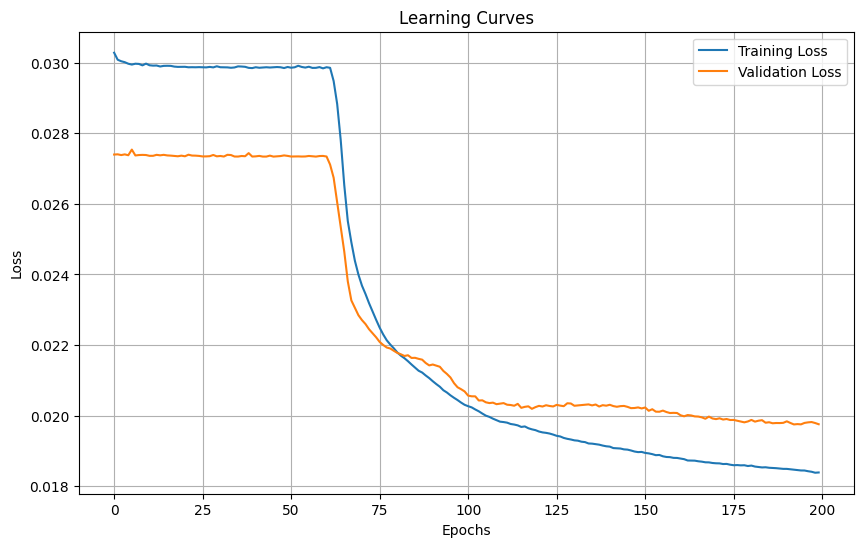

MAE = 0.5739130198649871
MSE = 0.538026618844621
R^2 = 0.2626135652694901


In [8]:
stoppping_a = EarlyStopping(
                        monitor="val_loss",
                        min_delta=0,
                        patience=50,
                        verbose=0,
                        mode="min",
                        baseline=None,
                        restore_best_weights=True,
                        start_from_epoch=0,
                    )

kernel = 'rbf'
learning_rate = 0.001
encoding_dim = 11
num_hidden_layer = 1

kqm_model = KQMModel(encoding_dim = encoding_dim, kernel_function = kernel, num_hidden_layerss = num_hidden_layer, use_dense_layers=False)
kqm_model.encoder.trainable = True

kqm_model.kqm_class_encoded.compile(
          optimizer=optimizers.Adam(learning_rate=learning_rate),
          loss=losses.mse)

np.random.seed(42)
indices = np.random.choice(X_train.shape[0], size=n_comp, replace=False)
selected_samples = X_train[indices]
kqm_model.kqm_unit_encoded.c_x.assign(kqm_model.encoder.predict(selected_samples,verbose=0))
#kqm_model.kqm_unit_encoded.c_x.assign(kqm_model.encoder.predict(X,verbose=0))

history = kqm_model.kqm_class_encoded.fit(X_train, y_train,
          validation_split = 0.2,
          epochs=200,
          batch_size=32,
          verbose=0,
          callbacks=[stoppping_a])

# Plotting the learning curves
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Learning Curves')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

y_pred = scaler.inverse_transform(kqm_model.kqm_class_encoded.predict(X_test, verbose = 0).reshape(-1, 1)).reshape(-1)
print('MAE =',mean_absolute_error(y_test, y_pred))
print('MSE =',mean_squared_error(y_test, y_pred))
print('R^2 =',r2_score(y_test, y_pred))

# Initializing weights `c_y`

ok


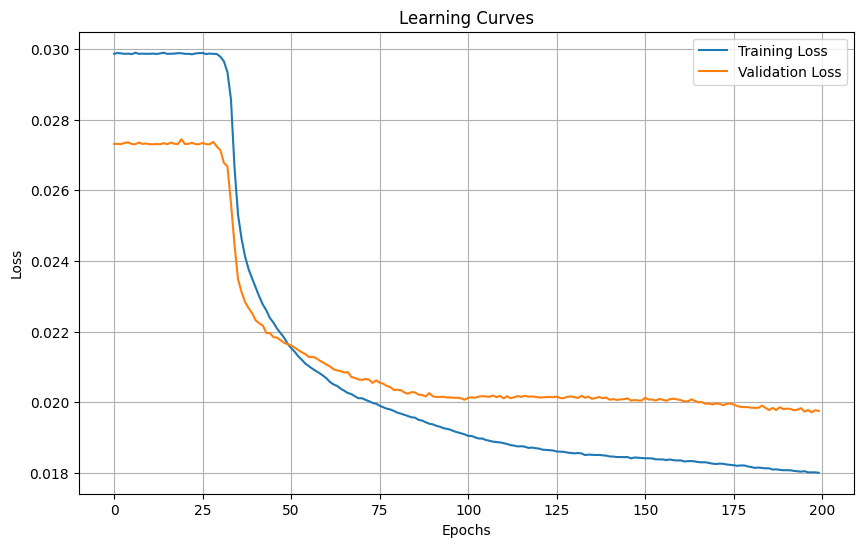

MAE = 0.570388867793939
MSE = 0.5341936691701559
R^2 = 0.26786677207369025


In [9]:
stoppping_a = EarlyStopping(
                        monitor="val_loss",
                        min_delta=0,
                        patience=100,
                        verbose=0,
                        mode="min",
                        baseline=None,
                        restore_best_weights=True,
                        start_from_epoch=0,
                    )

kernel = 'rbf'
learning_rate = 0.001
encoding_dim = 11
num_hidden_layer = 1

kqm_model = KQMModel(encoding_dim = encoding_dim, kernel_function = kernel, num_hidden_layerss = num_hidden_layer, use_dense_layers=False)
kqm_model.encoder.trainable = True

kqm_model.kqm_class_encoded.compile(
          optimizer=optimizers.Adam(learning_rate=learning_rate),
          loss=losses.mse)

np.random.seed(42)
indices = np.random.choice(X_train.shape[0], size=n_comp, replace=False)
selected_samples = X_train[indices]
selected_labels = y_train[indices]
cos_values = np.cos(selected_labels)
sin_values = np.sin(selected_labels)
kqm_model.kqm_unit_encoded.c_x.assign(kqm_model.encoder.predict(selected_samples,verbose=0))
kqm_model.kqm_unit_encoded.c_y.assign(np.column_stack((cos_values, sin_values)))
print('ok')

history = kqm_model.kqm_class_encoded.fit(X_train, y_train,
          validation_split = 0.2,
          epochs=200,
          batch_size=32,
          verbose=0,
          callbacks=[stoppping_a])

# Plotting the learning curves
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Learning Curves')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

y_pred = scaler.inverse_transform(kqm_model.kqm_class_encoded.predict(X_test, verbose = 0).reshape(-1, 1)).reshape(-1)
print('MAE =',mean_absolute_error(y_test, y_pred))
print('MSE =',mean_squared_error(y_test, y_pred))
print('R^2 =',r2_score(y_test, y_pred))

In [12]:
y_pred

array([5.70699  , 5.1569886, 7.05289  , ..., 6.7105865, 6.277222 ,
       5.865579 ], dtype=float32)

In [13]:
y_test

array([8, 5, 7, ..., 6, 6, 6])

# Hyper-parameter exploration

We are going to explore:
```
learning_rates = [1e-5, 5e-5, 1e-4, 5e-4, 1e-3, 5e-3, 1e-2, 1e-1]
kernels = ['rbf', 'cos']
```

In [16]:
# Defining hyperparams to explore
learning_rates = [1e-5, 5e-5, 1e-4, 5e-4, 1e-3, 5e-3, 1e-2, 1e-1]
kernels = ['rbf', 'cos']

# Some fixed hyper-params
encoding_dim = 11
num_hidden_layer = 1
n_comp=32

# For saving:
best_model = None
best_hyperparameters = None

In [17]:
class KQMModel:
    def __init__(self,
                 encoding_dim,
                 kernel_function,
                 num_hidden_layerss,
                 input_shape=(11,),
                 output_dim=2,
                 n_comp=n_comp,
                 sigma=0.1,
                 use_dense_layers=True):
        self.encoding_dim = encoding_dim
        self.kernel_function = kernel_function
        self.num_hidden_layerss = num_hidden_layerss
        self.input_shape = input_shape
        self.output_dim = output_dim
        self.n_comp = n_comp
        self.sigma = sigma
        self.use_dense_layers = use_dense_layers  # New parameter tio turn off the dense layer model
        self.encoder = None
        self.encoder_aux = None
        self.kqm_class_encoded = None
        self.kqm_class_out = None
        self.kqm_unit_encoded = None
        self.kqm_unit_out = None
        self.kernel_encoded = None  # almacenamos la instancia de kernel
        self.kernel_out = None  # almacenamos la instancia de kernel
        self.build_model()

    def build_model(self):
        inputs = Input(shape=self.input_shape)
        
        if self.use_dense_layers:
            encoded = Dense(self.encoding_dim, activation='relu')(inputs)
            encoded = Dropout(0.1)(encoded)
            if self.num_hidden_layerss == 2:
                encoded = Dense(self.encoding_dim, activation='relu')(encoded)
                encoded = Dropout(0.1)(encoded)
            out = Dense(self.encoding_dim)(encoded)
            encoded = Activation('tanh')(out)
        else:
            # Skip dense layers, directly output the input
            encoded = inputs
            out = inputs
            #self.encoding_dim=1
        
        self.encoder = Model(inputs, encoded)
        self.encoder_aux = Model(inputs, out)

        self.kqm_class_encoded, self.kqm_unit_encoded, self.kernel_encoded = self.build_kqm_class(inputs, encoded)
        self.kqm_class_out, self.kqm_unit_out, self.kernel_out = self.build_kqm_class(inputs, out)

    def build_kqm_class(self, inputs, tensor):
        if self.kernel_function == 'rbf':
          kernel = kqm.RBFKernelLayer(sigma=self.sigma, dim=self.encoding_dim)
        else:
          kernel = kqm.CosineKernelLayer()
        kqm_unit = kqm.KQMUnit(kernel=kernel,
                               dim_x=self.encoding_dim,
                               dim_y=self.output_dim,
                               n_comp=self.n_comp)

        rho_x = kqm.pure2dm(tensor)
        rho_y = kqm_unit(rho_x)
        probs = kqm.dm2discrete(rho_y)
        probs_0_sqrt = tf.sqrt(probs[:, 0])  # Assuming probs is a 2D array, take the first column
        theta = tf.acos(probs_0_sqrt)
        return Model(inputs, theta), kqm_unit, kernel

    def summary(self):
        print("Encoder:")
        self.encoder.summary()
        print("Encoder Aux:")
        self.encoder_aux.summary()
        print("KQM Class Encoded:")
        self.kqm_class_encoded.summary()
        print("KQM Class Out:")
        self.kqm_class_out.summary()

In [18]:
best_MSE = 1000

for lr, kernel in itertools.product(learning_rates, kernels):
    print(f"Running experiment with learning_rate={lr} and kernel={kernel}")

    stoppping_a = EarlyStopping(
                            monitor="val_loss",
                            min_delta=0,
                            patience=50,
                            verbose=0,
                            mode="min",
                            baseline=None,
                            restore_best_weights=True,
                            start_from_epoch=0,
                        )
    
    kqm_model = KQMModel(encoding_dim = encoding_dim, kernel_function = kernel, num_hidden_layerss = num_hidden_layer, use_dense_layers=False)
    kqm_model.encoder.trainable = True
    
    kqm_model.kqm_class_encoded.compile(
              optimizer=optimizers.Adam(learning_rate=lr),
              loss=losses.mse)
    
    np.random.seed(42)
    indices = np.random.choice(X_train.shape[0], size=n_comp, replace=False)
    selected_samples = X_train[indices]
    kqm_model.kqm_unit_encoded.c_x.assign(kqm_model.encoder.predict(selected_samples,verbose=0))
    #kqm_model.kqm_unit_encoded.c_x.assign(kqm_model.encoder.predict(X,verbose=0))
    
    kqm_model.kqm_class_encoded.fit(X_train, y_train,
              validation_split = 0.2,
              epochs=200,
              batch_size=32,
              verbose=0,
              callbacks=[stoppping_a])
    
    y_pred = scaler.inverse_transform(kqm_model.kqm_class_encoded.predict(X_test, verbose = 0).reshape(-1, 1)).reshape(-1)
    print('MAE =',mean_absolute_error(y_test, y_pred))
    print('MSE =',mean_squared_error(y_test, y_pred))
    print('R^2 =',r2_score(y_test, y_pred))

    if mean_squared_error(y_test, y_pred) < best_MSE:
        best_MSE = mean_squared_error(y_test, y_pred)
        best_model = kqm_model
        best_hyperparameters = (lr, kernel)
        print("New best model")

print("Best hyper-parameters:", best_hyperparameters)

Running experiment with learning_rate=1e-05 and kernel=rbf
MAE = 0.6639392512883896
MSE = 0.7290569921409936
R^2 = 0.0007989989330778879
New best model
Running experiment with learning_rate=1e-05 and kernel=cos
MAE = 0.6430822237943992
MSE = 0.6391797889822934
R^2 = 0.12397920615602809
New best model
Running experiment with learning_rate=5e-05 and kernel=rbf
MAE = 0.6308661480439015
MSE = 0.6307324496244723
R^2 = 0.1355566137300228
New best model
Running experiment with learning_rate=5e-05 and kernel=cos
MAE = 0.6313955986805451
MSE = 0.6178101245069612
R^2 = 0.1532671635673012
New best model
Running experiment with learning_rate=0.0001 and kernel=rbf
MAE = 0.6618801405490973
MSE = 0.7257853503739072
R^2 = 0.005282911389914879
Running experiment with learning_rate=0.0001 and kernel=cos
MAE = 0.6316633733113607
MSE = 0.6192172553774337
R^2 = 0.1513386359081954
Running experiment with learning_rate=0.0005 and kernel=rbf
MAE = 0.5709809997754219
MSE = 0.5429771702880085
R^2 = 0.2558286417

```
Running experiment with learning_rate=0.005 and kernel=rbf
MAE = 0.5405781868176582
MSE = 0.49454100299689785
R^2 = 0.32221229534881646
New best model
```

## Adding an Encoder

We are going to explore:
```
learning_rates = [1e-5, 5e-5, 1e-4, 5e-4, 1e-3, 5e-3, 1e-2, 1e-1]
kernels = ['rbf', 'cos']
encoding_dim = [6, 8, 16]
num_hidden_layer = [1,2]
```

In [14]:
# Defining hyperparams to explore
learning_rates = [1e-5, 5e-5, 1e-4, 5e-4, 1e-3, 5e-3, 1e-2, 1e-1]
kernels = ['rbf', 'cos']
encoding_dim = [11, 16, 32]
num_hidden_layers = [1,2]

# Some fixed hyper-params

n_comp=32

# For saving:
best_model = None
best_hyperparameters = None

In [15]:
class KQMModel:
    def __init__(self,
                 encoding_dim,
                 kernel_function,
                 num_hidden_layerss,
                 input_shape=(11,),
                 output_dim=2,
                 n_comp=n_comp,
                 sigma=0.1,
                 use_dense_layers=True):
        self.encoding_dim = encoding_dim
        self.kernel_function = kernel_function
        self.num_hidden_layerss = num_hidden_layerss
        self.input_shape = input_shape
        self.output_dim = output_dim
        self.n_comp = n_comp
        self.sigma = sigma
        self.use_dense_layers = use_dense_layers  # New parameter tio turn off the dense layer model
        self.encoder = None
        self.encoder_aux = None
        self.kqm_class_encoded = None
        self.kqm_class_out = None
        self.kqm_unit_encoded = None
        self.kqm_unit_out = None
        self.kernel_encoded = None  # almacenamos la instancia de kernel
        self.kernel_out = None  # almacenamos la instancia de kernel
        self.build_model()

    def build_model(self):
        inputs = Input(shape=self.input_shape)
        
        if self.use_dense_layers:
            encoded = Dense(self.encoding_dim, activation='relu')(inputs)
            encoded = Dropout(0.1)(encoded)
            if self.num_hidden_layerss == 2:
                encoded = Dense(self.encoding_dim, activation='relu')(encoded)
                encoded = Dropout(0.1)(encoded)
            out = Dense(self.encoding_dim)(encoded)
            encoded = Activation('tanh')(out)
        else:
            # Skip dense layers, directly output the input
            encoded = inputs
            out = inputs
            #self.encoding_dim=1
        
        self.encoder = Model(inputs, encoded)
        self.encoder_aux = Model(inputs, out)

        self.kqm_class_encoded, self.kqm_unit_encoded, self.kernel_encoded = self.build_kqm_class(inputs, encoded)
        self.kqm_class_out, self.kqm_unit_out, self.kernel_out = self.build_kqm_class(inputs, out)

    def build_kqm_class(self, inputs, tensor):
        if self.kernel_function == 'rbf':
          kernel = kqm.RBFKernelLayer(sigma=self.sigma, dim=self.encoding_dim)
        else:
          kernel = kqm.CosineKernelLayer()
        kqm_unit = kqm.KQMUnit(kernel=kernel,
                               dim_x=self.encoding_dim,
                               dim_y=self.output_dim,
                               n_comp=self.n_comp)

        rho_x = kqm.pure2dm(tensor)
        rho_y = kqm_unit(rho_x)
        probs = kqm.dm2discrete(rho_y)
        probs_0_sqrt = tf.sqrt(probs[:, 0])  # Assuming probs is a 2D array, take the first column
        theta = tf.acos(probs_0_sqrt)
        return Model(inputs, theta), kqm_unit, kernel

    def summary(self):
        print("Encoder:")
        self.encoder.summary()
        print("Encoder Aux:")
        self.encoder_aux.summary()
        print("KQM Class Encoded:")
        self.kqm_class_encoded.summary()
        print("KQM Class Out:")
        self.kqm_class_out.summary()

In [16]:
best_MSE = 1000

for lr, kernel, encoding_dim, num_hidden_layer in itertools.product(learning_rates, kernels, encoding_dim, num_hidden_layers):
    print(f"Running experiment with learning_rate={lr}, kernel={kernel}, encoding_dim={encoding_dim} and num_h_l={num_hidden_layer}")

    stoppping_a = EarlyStopping(
                            monitor="val_loss",
                            min_delta=0,
                            patience=50,
                            verbose=0,
                            mode="min",
                            baseline=None,
                            restore_best_weights=True,
                            start_from_epoch=0,
                        )
    
    kqm_model = KQMModel(encoding_dim = encoding_dim, kernel_function = kernel, num_hidden_layerss = num_hidden_layer, use_dense_layers=True)
    kqm_model.encoder.trainable = True
    
    kqm_model.kqm_class_encoded.compile(
              optimizer=optimizers.Adam(learning_rate=lr),
              loss=losses.mse)
    
    np.random.seed(42)
    indices = np.random.choice(X_train.shape[0], size=n_comp, replace=False)
    selected_samples = X_train[indices]
    kqm_model.kqm_unit_encoded.c_x.assign(kqm_model.encoder.predict(selected_samples,verbose=0))
    #kqm_model.kqm_unit_encoded.c_x.assign(kqm_model.encoder.predict(X,verbose=0))
    
    kqm_model.kqm_class_encoded.fit(X_train, y_train,
              validation_split = 0.2,
              epochs=200,
              batch_size=32,
              verbose=0,
              callbacks=[stoppping_a])
    
    y_pred = scaler.inverse_transform(kqm_model.kqm_class_encoded.predict(X_test, verbose = 0).reshape(-1, 1)).reshape(-1)
    print('MAE =',mean_absolute_error(y_test, y_pred))
    print('MSE =',mean_squared_error(y_test, y_pred))
    print('R^2 =',r2_score(y_test, y_pred))

    if mean_squared_error(y_test, y_pred) < best_MSE:
        best_MSE = mean_squared_error(y_test, y_pred)
        best_model = kqm_model
        best_hyperparameters = (lr, kernel, encoding_dim, num_hidden_layer)
        print("New best model")

print("Best hyper-parameters:", best_hyperparameters)

Running experiment with learning_rate=1e-05, kernel=rbf, encoding_dim=11 and num_h_l=1
MAE = 0.639921143360627
MSE = 0.6455040116620537
R^2 = 0.11531161267471546
New best model
Running experiment with learning_rate=1e-05, kernel=rbf, encoding_dim=11 and num_h_l=2
MAE = 0.6398120104960906
MSE = 0.6705843989583989
R^2 = 0.0809379651220592
Running experiment with learning_rate=1e-05, kernel=rbf, encoding_dim=16 and num_h_l=1
MAE = 0.6505650676825108
MSE = 0.684259610344079
R^2 = 0.06219555533287957
Running experiment with learning_rate=1e-05, kernel=rbf, encoding_dim=16 and num_h_l=2
MAE = 0.6013723603273049
MSE = 0.5764560026616267
R^2 = 0.2099445981046968
New best model
Running experiment with learning_rate=1e-05, kernel=rbf, encoding_dim=32 and num_h_l=1
MAE = 0.6606823539733887
MSE = 0.7222879281451493
R^2 = 0.010076264762558629
Running experiment with learning_rate=1e-05, kernel=rbf, encoding_dim=32 and num_h_l=2
MAE = 0.636129138653095
MSE = 0.6509019828058836
R^2 = 0.10791348299653

```
unning experiment with learning_rate=0.005, kernel=cos, encoding_dim=32 and num_h_l=2
MAE = 0.518174997598697
MSE = 0.4483027554212262
R^2 = 0.38558361441334343
New best model
```

So, an encoder does improves the performance in this case.

In [17]:
y_test.max(), y_test.mean(), y_test.min()

(9, 5.814358974358974, 3)